<img
src="http://www.telecom-em.eu/sites/default/files/logoimt2016.JPG"
WIDTH=180 HEIGHT=180>

<CENTER>
</br>
<p><font size="5">  TAF MCE - Machine Learning  </font></p>
<p><font size="5">  Decision trees </font></p>
<p><font size="4">  By Kevin Michalewicz and Fatima-Zahra Kerdad </font></p>
<p><font size="3"></br>Fall 2021</font></br></div>
<p><span style="color:blue">pierre.tandeo@imt-atlantique.fr</span>
</p>
</CENTER>

----------------------------

The goal of this lab is to implement and visualize decision trees. Both aspects of classification and regression will be studied using simple examples. Cross-validation procedures will be used to tune the important parameters of the trees. Monte Carlo methods, using an ensemble of decision trees, are also discussed.

In [1]:
# Install graphviz library (needed to plot a tree)
#!pip install graphviz --upgrade #or: !pip install python-graphviz

In [2]:
## Import classic libraries (Matplotlib and PyLab)
%matplotlib inline
%pylab inline

# Import scikit-learn functions
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import log_loss

# Import pandas
import pandas as pd

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Figure size
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


## I - Course example on regression trees

The decision tree is presented in the course using a simple regression problem. This is corresponding to a simple regression between $y$ and $x$, using a $\sin$ function.

> 1. Generate x and y (adding an additive random noise of mean=0 and std=0.25 on y)
> 2. Apply a single regression tree with depth=1,10
> 3. Optimize the depth of the tree using cross-validation
> 4. Compute and plot the tree with the optimal depth
> 5. Implement a regression forest with the optimal depth

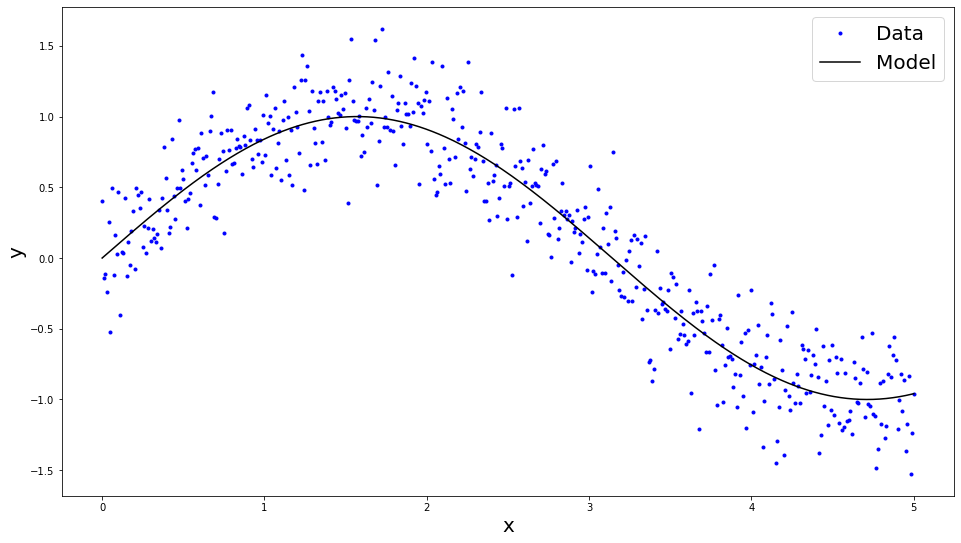

In [3]:
# 1. Generate x and y (adding an additive random noise of mean=0 and std=0.25 on y)

# Data generation
random.seed(1) # setting seed for reproducability
n = 500 # number of samples
x = array([linspace(0, 5, n)]).T
y = sin(x) + 0.25*randn(n, 1)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
legend([line1, line2], ['Data', 'Model'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)
show()

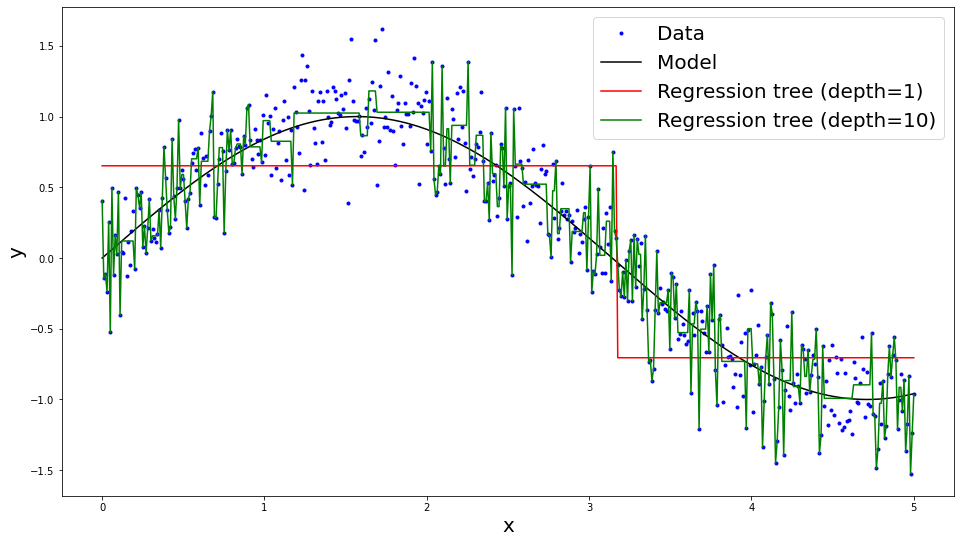

In [4]:
# 2. Apply a single regression tree with depth=1,10

# Build the tree (with depth=1)
reg_tree_example_1 = DecisionTreeRegressor(max_depth=1)
reg_tree_example_1.fit(x, y)
y_tree_example_1 = reg_tree_example_1.predict(x)

# Build the trees (with depth=10)
reg_tree_example_10 = DecisionTreeRegressor(max_depth=10)
reg_tree_example_10.fit(x, y)
y_tree_example_10 = reg_tree_example_10.predict(x)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
line3, = plot(x, y_tree_example_1, '-r')
line4, = plot(x, y_tree_example_10, '-g')
legend([line1, line2, line3, line4], ['Data', 'Model', 'Regression tree (depth=1)', 'Regression tree (depth=10)'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)
show()

**Comment:** for a depth of 1 we can see that the curve is underfitted. By contrast, there is overfitting with depth equal to 10. An intermediate value should be the optimal and we will find it in the next section.

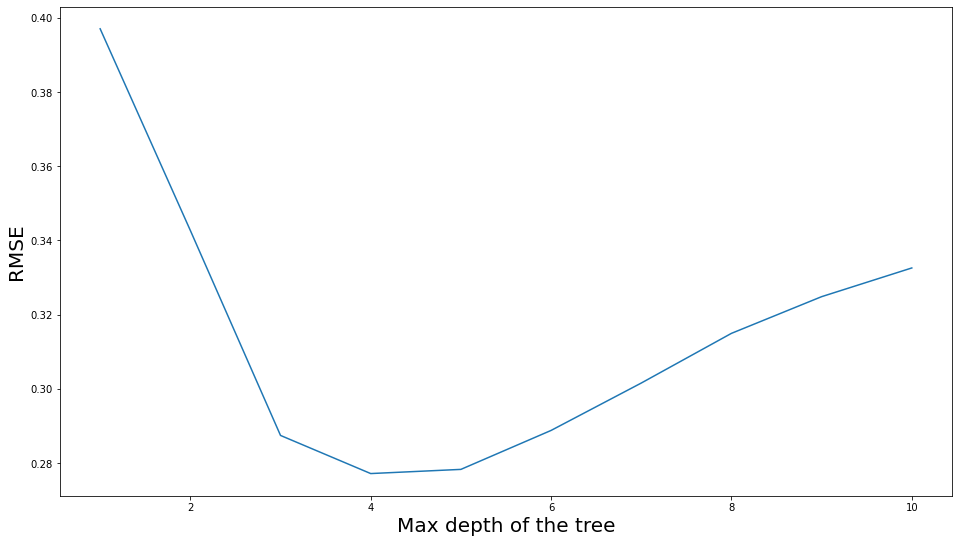

In [5]:
# 3. Optimize the depth of the tree using cross-validation

# Define the cvp (cross-validation procedure) with random 1000 samples, 2/3 training size, and 1/3 test size
cvp = ShuffleSplit(n_splits=1000, test_size=1/3, train_size=2/3)

# Define the max depths between 1 and 10
n_depths = 10
depths = linspace(1, 10, n_depths)

# Loop on the max_depth parameter and compute median RMSE
tab_RMSE_tree = zeros(n_depths)
for i in range(n_depths):
    reg_tree = DecisionTreeRegressor(max_depth=depths[i])
    tab_RMSE_tree[i] = median(sqrt(-cross_val_score(reg_tree, x, y, scoring='neg_mean_squared_error', cv=cvp)))

# Plot
plot(depths, tab_RMSE_tree)
xlabel('Max depth of the tree', size=20)
ylabel('RMSE', size=20)
show()

**Comment:** We can conclude that the optimal depth is equal to 4 as it minimizes the RMSE.

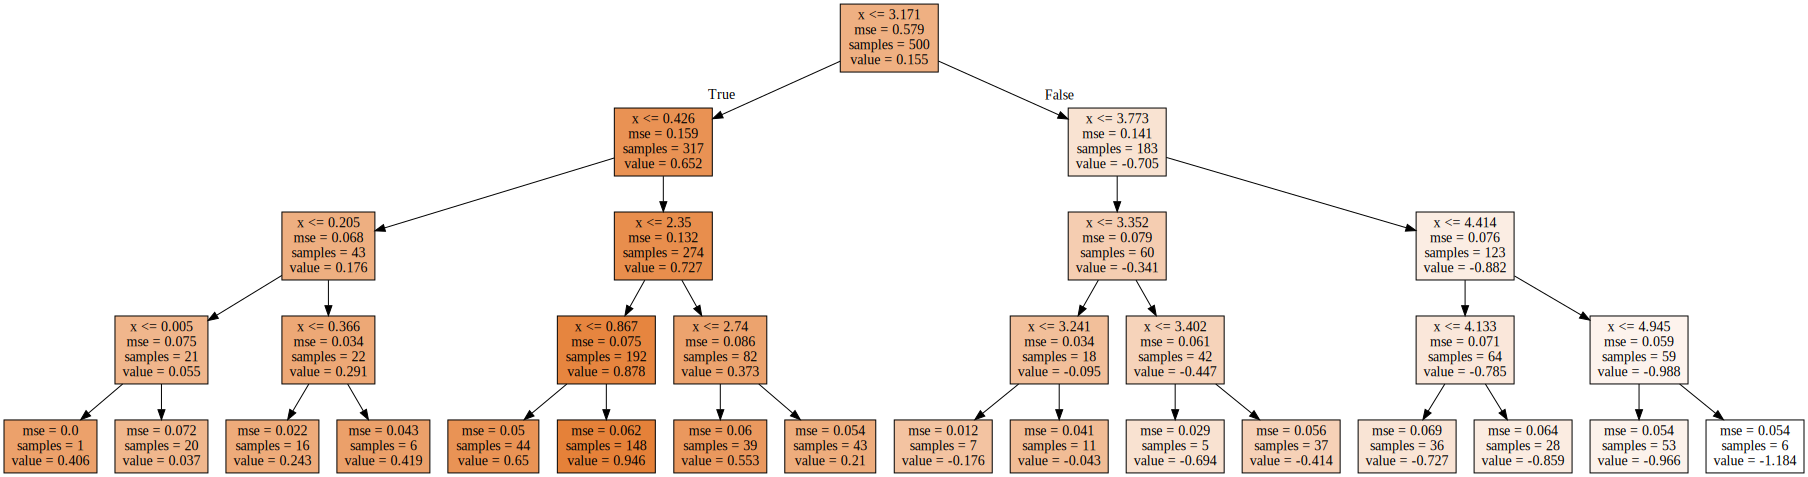

In [6]:
# 4. Compute and plot the tree with the optimal depth

# Adjust regression tree with optimal depth
reg_tree = DecisionTreeRegressor(max_depth=argmin(tab_RMSE_tree)+1)
reg_tree.fit(x, y)
y_tree = reg_tree.predict(x)

# Export the tree to "plot_tree.pdf"
plot_tree = export_graphviz(reg_tree, out_file=None, feature_names=['x'], filled=True) 
graph = Source(plot_tree) 
graph.render("reg_tree")

# Plot the tree
graph

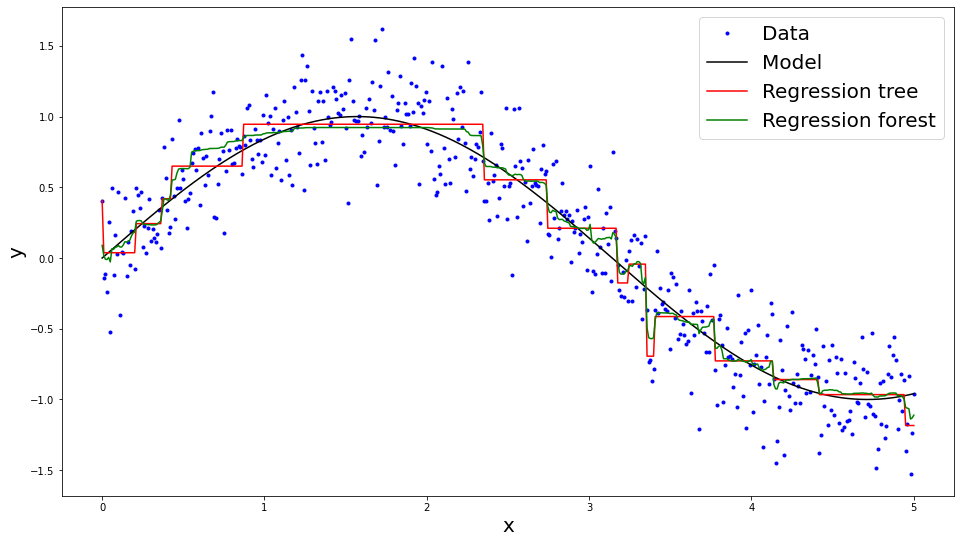

In [7]:
## 5. Implement a regression forest with the optimal depth

# Adjust regression forest using 1000 trees
reg_forest = RandomForestRegressor(n_estimators=1000, max_depth=argmin(tab_RMSE_tree)+1)
reg_forest.fit(x, y)
y_forest = reg_forest.predict(x)

# Plot
line1, = plot(x, y, '.b')
line2, = plot(x, sin(x), '-k')
line3, = plot(x, y_tree, '-r')
line4, = plot(x, y_forest, '-g')
legend([line1, line2, line3, line4], ['Data', 'Model', 'Regression tree', 'Regression forest'], prop={'size': 20})
xlabel('x', size=20)
ylabel('y', size=20)
show()

**Comment:** We can see that those predictions get close to the ground truth model. However, the regression forest is smoother than the regression tree.

## II - Single tree for binary classification

Here, we use a binary classification on the Titanic historical dataset. The goal is to understand the rules infered by the classification tree to predict the output variable (i.e., did people died or survived).

> 1. Import X and y
> 2. Use a cross-validation procedure to tune the depth of the classification tree
> 3. Plot the best classification tree
> 4. Explain the rules obtained to get the classification

In [8]:
# 1. Import X and y

# Import dataset
data_titanic = pd.read_csv('titanic.csv')

# Read X and y
X = data_titanic.drop(['Survived'], axis=1).values
y = data_titanic['Survived'].values
y = (y>0.5) # transform to binary data

Here are some details about the dataset:
- Survived (False --> no, True --> yes), this is y
- Pclass (1 --> 1st class, 2 --> 2nd class, 3 --> 3rd class)
- Sex (0 --> female, 1 --> male)
- Age (0 --> less than 16, 1 --> between 16 and 32, 2 --> between 32 and 48, 3 --> between 48 and 64, 4 --> more than 64)
- FamilySize (number of members in the family)
- Title (1 --> Mr, 2 --> Master, 3 --> Mrs, 4 --> Miss, 5 --> rare)

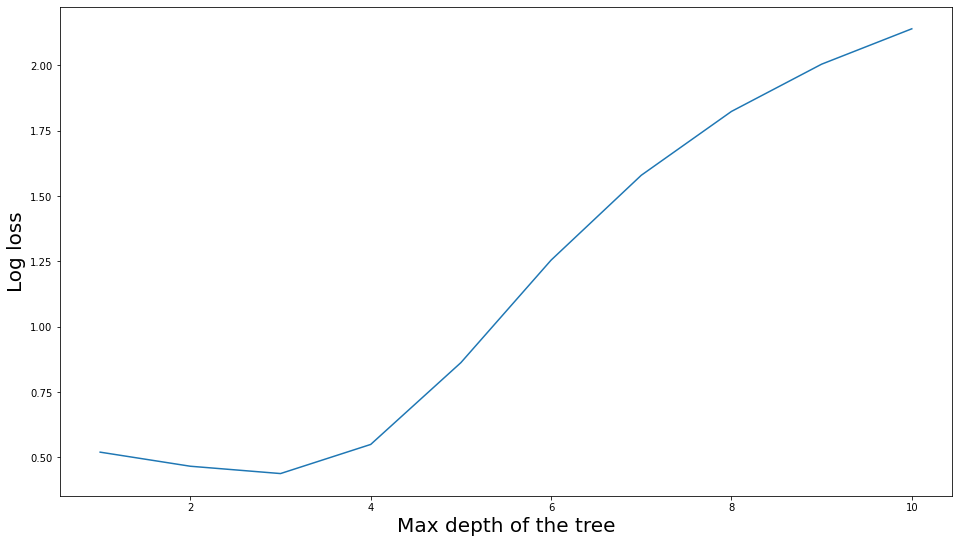

In [9]:
# 2. Use a cross-validation procedure to tune the depth of the classification tree

cvp = ShuffleSplit(n_splits=1000, test_size=0.25, train_size=0.75)

# Define the max depths between 1 and 10
n_depths = 10
depths = linspace(1, 10, n_depths)

# Loop on the max_depth parameter and compute median of the binary cross-entropy
tab_log_loss_tree = zeros(n_depths)
for i in range(n_depths):
    class_tree = DecisionTreeClassifier(max_depth=depths[i])
    tab_log_loss_tree[i] = median(-cross_val_score(class_tree, X, y, scoring='neg_log_loss', cv=cvp))

# Plot
plot(depths, tab_log_loss_tree)
xlabel('Max depth of the tree', size=20)
ylabel('Log loss', size=20)
show()

**Comment:** In this case the optimal is found in 3 as it minimizes the binary cross-entropy (log loss).

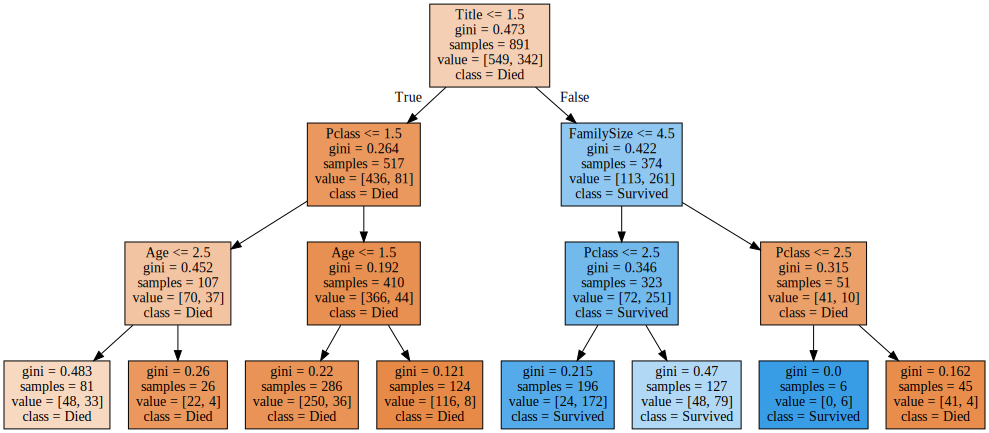

In [10]:
# 3. Plot the best classification tree

class_tree = DecisionTreeClassifier(max_depth=argmin(tab_log_loss_tree)+1)
class_tree.fit(X, y)
y_tree = class_tree.predict(X)

# Export the tree to "plot_tree.pdf"
plot_tree = export_graphviz(class_tree, out_file=None, feature_names=['Pclass', 'Sex', 'Age', 'FamilySize', 'Title'], class_names=['Died', 'Survived'], filled=True) 
graph = Source(plot_tree) 
graph.render("class_tree")

# Plot the tree
graph

**Explanation of the rules obtained to get the classification:**

- Those who have the highest living probability are non-Misters (without the Mr. title) belonging to:
    - A small family (1-4 members).
    - A big family (+4 members) in first or second class.
- The rest of the tree leaves are linked to higher death probabilities.

## III - Multiple trees for binary classification

We consider another binary classification problem. The goal is to visualize the results of decision trees in nonlinear problems.

> 1. Generate data (x1, x2, y)
> 2. Apply classification trees with depth=1,2,3,4
> 3. Implement and compare the classification forest with depth=3 and the ada boost classifier

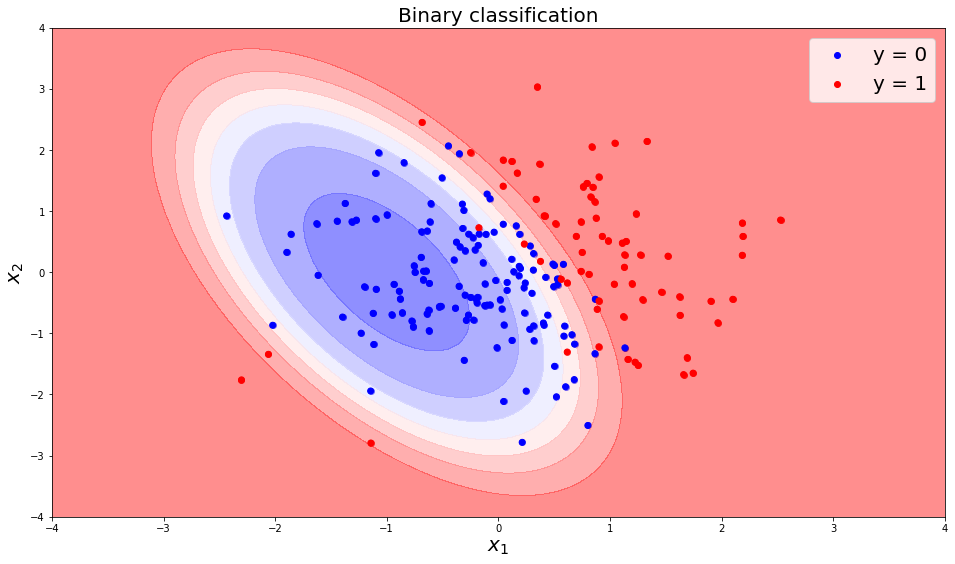

In [48]:
# 1. Generate the data

# Input variables
random.seed(1) # setting seed for reproducability
n = 200 # number of samples
x1 = randn(n, 1)
x2 = randn(n, 1)
x = hstack((x1, x2))

# True parameters
w0 = -0.5
w1 = 1.5
w2 = 0.5
w11 = 0.75
w22 = 0.25
w12 = 0.5

# Noise
epsilon = randn(n, 1)/3

# Output variable
y_noise = tanh(w0 + w1*x1 + w2*x2 + w11*x1**2 + w22*x2**2 + w12*x1*x2 + epsilon)
y = (y_noise>0.5) # transform to binary data

# For visualization
X1, X2 = meshgrid(linspace(-4, 4, 100), linspace(-4, 4, 100))
X = vstack((ravel(X1), ravel(X2))).T
Y = tanh(w0 + w1*X1 + w2*X2 + w11*X1**2 + w22*X2**2 + w12*X1*X2)

# Plot data
scatter(x1[y==0], x2[y==0], c='b')
scatter(x1[y==1], x2[y==1], c='r')
contourf(X1, X2, Y, cmap='bwr', alpha=0.5)
scatter(x1, x2, c=y, cmap='bwr')
legend(['y = 0', 'y = 1'], prop={'size': 20})
xlabel("$x_1$", fontsize=20)
ylabel("$x_2$", fontsize=20)
title('Binary classification', size=20)
show()

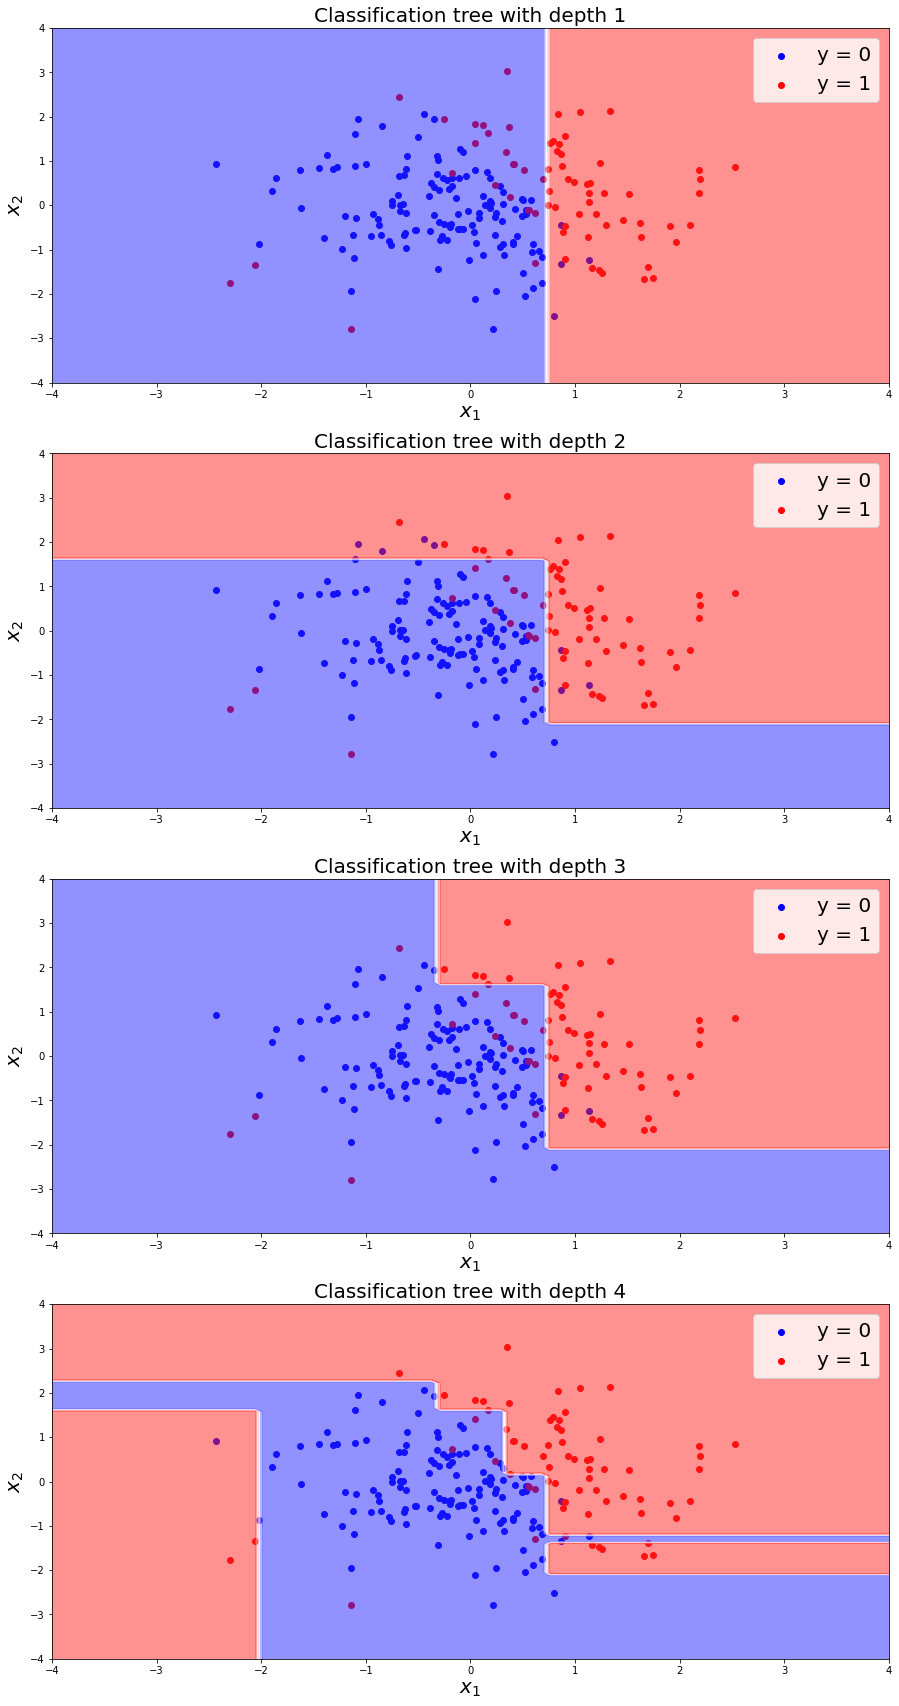

In [49]:
# 2. Apply classification trees with depth=1,2,3,4

fig, axs = plt.subplots(4, 1, figsize=(15,30))
y_tree_examples = []
class_tree_examples = [DecisionTreeClassifier(max_depth=i) for i in range(1,5)]

for i in range(4):
    class_tree_examples[i].fit(x, y)
    y_tree_examples.append(class_tree_examples[i].predict(x))
    # Plotting
    axs[i].scatter(x1[y==0], x2[y==0], c='b')
    axs[i].scatter(x1[y==1], x2[y==1], c='r')
    axs[i].legend(['y = 0', 'y = 1'], prop={'size': 20})
    axs[i].contourf(X1, X2, class_tree_examples[i].predict(X).reshape(shape(Y)), cmap='bwr', alpha=0.5)
    axs[i].set_xlabel('$x_1$', size=20)
    axs[i].set_ylabel('$x_2$', size=20)
    axs[i].set_title('Classification tree with depth {}'.format(i+1), size=20)
show()

**Comment:** we can see that the two regions turn more and more complex as the depth increases so as to be able to include every datapoint of each class.

In [50]:
# 3. Implement and compare the classification forest with depth=3 and the ada boost classifier

x1_test = randn(n, 1)
x2_test = randn(n, 1)
x_test = hstack((x1_test, x2_test))
y_noise_test = tanh(w0 + w1*x1_test + w2*x2_test + w11*x1_test**2 + w22*x2_test**2 + w12*x1_test*x2_test + epsilon)
y_test = (y_noise_test>0.5) # transform to binary data

class_forest = RandomForestClassifier(n_estimators=1000, max_depth=3)
class_forest.fit(x, y)
y_forest = (class_forest.predict(x_test))>0.5

class_ada = AdaBoostClassifier(n_estimators=1000)
class_ada.fit(x, y)
y_ada = (class_ada.predict(x_test))>0.5

print('The binary cross-entropy is {} for the forest case.'.format(log_loss(y_test, y_forest)))
print('The binary cross-entropy is {} for the ada boost classifier case.'.format(log_loss(y_test, y_ada)))

The binary cross-entropy is 2.7631101075671576 for the forest case.
The binary cross-entropy is 2.590444211502661 for the ada boost classifier case.


**Comments**:

We chose the **binary cross-entropy** *(log loss)* metric because it consists of two terms. The first one cancels out if the target is zero and the other one gets a zero value if the target is one. 

<img
src="https://androidkt.com/wp-content/uploads/2021/05/Selection_099-1024x200.png"
WIDTH=600 HEIGHT=240>

Then it penalizes according to how near is the predicted $\hat{y}$ to the ground truth $y$, and that is why it is useful as a binary classification metric.

In this case, the *ada boost classifier* clearly outperforms the forest classificator as it uses a combined classifier (and the problem is highly nonlinear). The other solution proposes many random trees, makes predictions and gives as output the class that came up the more often. In other words, the idea is to count the number of times every tree has predicted a certain class, then take the argmax. However, it does not work well if the problem is highly nonlinear.